In [11]:
import os
import sys

print("python:", sys.executable)
print("cwd:", os.getcwd())

os.makedirs("assets", exist_ok=True)
os.makedirs("output", exist_ok=True)
print("made folders:", os.path.isdir("assets"), os.path.isdir("output"))

python: c:\Users\economy\Desktop\3-2\기계학습\trade_comovement\.venv\Scripts\python.exe
cwd: c:\Users\economy\Desktop\3-2\기계학습\trade_comovement
made folders: True True


Top pair: XIIEJNEE -> GMBFCMIU | best_lag: 2 | abs_max: 0.9959600616133952


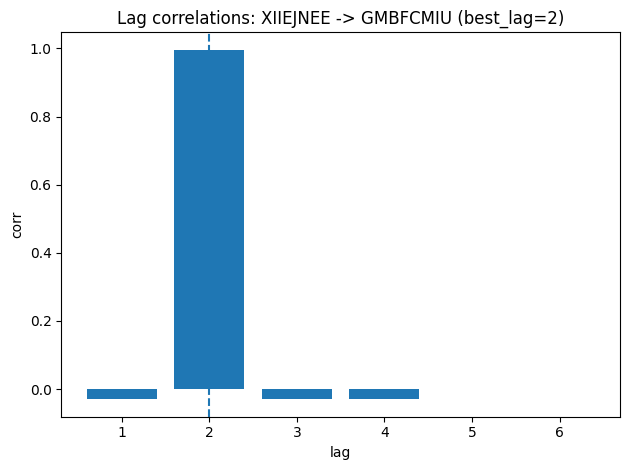

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAX_LAG = 6

def load_pivot(train_path="data/train.csv"):
    df = pd.read_csv(train_path)
    monthly = df.groupby(["item_id", "year", "month"], as_index=False)["value"].sum()
    monthly["ym"] = pd.to_datetime(
        monthly["year"].astype(str) + "-" +
        monthly["month"].astype(str).str.zfill(2) + "-01"
    )
    pivot = monthly.pivot(index="item_id", columns="ym", values="value")
    return pivot.fillna(0).sort_index(axis=1)

def safe_corr(a, b):
    if np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return float(np.corrcoef(a, b)[0, 1])

def lag_corrs(a, b, max_lag=6):
    corrs = []
    for lag in range(1, max_lag + 1):
        if len(a) <= lag:
            corrs.append(0.0)
        else:
            corrs.append(safe_corr(a[:-lag], b[lag:]))
    return np.array(corrs)

pivot = load_pivot("data/train.csv")
items = pivot.index.tolist()

best = None  # (abs_corr, leader, follower, best_lag, corrs)
for leader in items:
    a = pivot.loc[leader].values
    for follower in items:
        if leader == follower:
            continue
        b = pivot.loc[follower].values
        corrs = lag_corrs(a, b, MAX_LAG)
        abs_max = np.max(np.abs(corrs))
        best_lag = int(np.argmax(np.abs(corrs)) + 1)
        if (best is None) or (abs_max > best[0]):
            best = (abs_max, leader, follower, best_lag, corrs)

abs_max, leader, follower, best_lag, corrs = best
print("Top pair:", leader, "->", follower, "| best_lag:", best_lag, "| abs_max:", abs_max)

lags = np.arange(1, MAX_LAG + 1)
plt.figure()
plt.bar(lags, corrs)
plt.axvline(best_lag, linestyle="--")
plt.title(f"Lag correlations: {leader} -> {follower} (best_lag={best_lag})")
plt.xlabel("lag")
plt.ylabel("corr")
plt.tight_layout()
plt.savefig("assets/lag_corr_example.png", dpi=200)
plt.show()

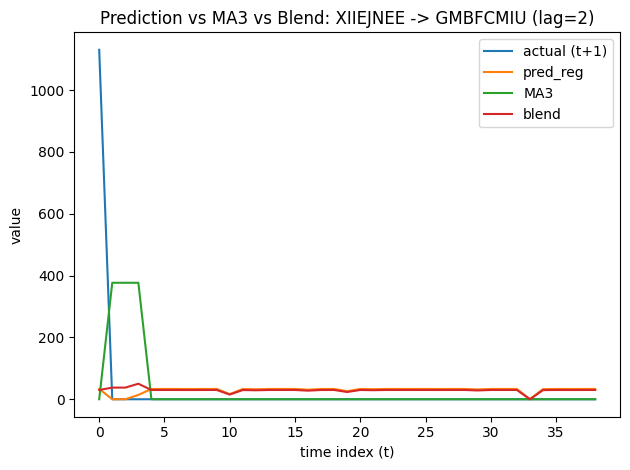

In [14]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

BLEND_ALPHA = 0.9

def ma3(b, t):
    if t < 2:
        return b[t]
    return (b[t] + b[t-1] + b[t-2]) / 3.0

a = pivot.loc[leader].values
b = pivot.loc[follower].values
lag = best_lag

X, y, ts = [], [], []
for t in range(lag + 1, len(b) - 1):
    X.append([b[t], b[t-1], a[t-lag]])
    y.append(b[t+1])
    ts.append(t)

X = np.array(X)
y = np.array(y)

reg = LinearRegression()
reg.fit(X, y)

pred_reg_list, pred_ma3_list, pred_blend_list, actual_list = [], [], [], []
for t in ts:
    x = np.array([[b[t], b[t-1], a[t-lag]]])
    pred_reg = float(reg.predict(x)[0])
    base = ma3(b, t)
    pred_blend = BLEND_ALPHA * pred_reg + (1 - BLEND_ALPHA) * base

    pred_reg_list.append(max(pred_reg, 0))
    pred_ma3_list.append(max(base, 0))
    pred_blend_list.append(max(pred_blend, 0))
    actual_list.append(max(b[t+1], 0))

plt.figure()
plt.plot(actual_list, label="actual (t+1)")
plt.plot(pred_reg_list, label="pred_reg")
plt.plot(pred_ma3_list, label="MA3")
plt.plot(pred_blend_list, label="blend")
plt.title(f"Prediction vs MA3 vs Blend: {leader} -> {follower} (lag={lag})")
plt.xlabel("time index (t)")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.savefig("assets/blend_compare.png", dpi=200)
plt.show()


In [4]:
!python src/run_final.py

Saved: output/baseline_corr_034.csv



find_pairs: 100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


In [5]:
!python src/run_exp_xgb.py

Saved: output/exp_xgb_tau022_k3000.csv



build_pair_features: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]

score_all_pairs: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]
